<a href="https://colab.research.google.com/github/issatyajit/NYC-taxi-time-prediction/blob/main/NYC_Taxi_Trip_Time_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df=pd.read_csv('/content/drive/MyDrive/Almabetter/NYC Taxi Data.csv')

In [4]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
#First we check for null values and repeated values

In [6]:
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#So, the given dataset has no null values

In [7]:
df[df.duplicated()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [89]:
#The given dataframe has no duplicated values, so we drop the useless columns now

In [8]:
df=df.drop(columns=['id'])

#Now let's see the mean of lat and long and see the location

In [9]:
df['pickup_latitude'].mean(),df['pickup_longitude'].mean()

(40.750920908391734, -73.97348630489282)

In [10]:
import folium
folium.Map([df['pickup_latitude'].mean(),df['pickup_longitude'].mean()], zoom_start=12)

#Now we extract each variable from datetime columns

In [11]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_min'] = df['pickup_datetime'].dt.minute
df['pickup_week'] = df['pickup_datetime'].dt.week

In [94]:
df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,17,24,11
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,0,43,23
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,11,35,3
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,19,32,14
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,13,30,12


#Now we plot the distribution plot

In [12]:
df1=df.copy()

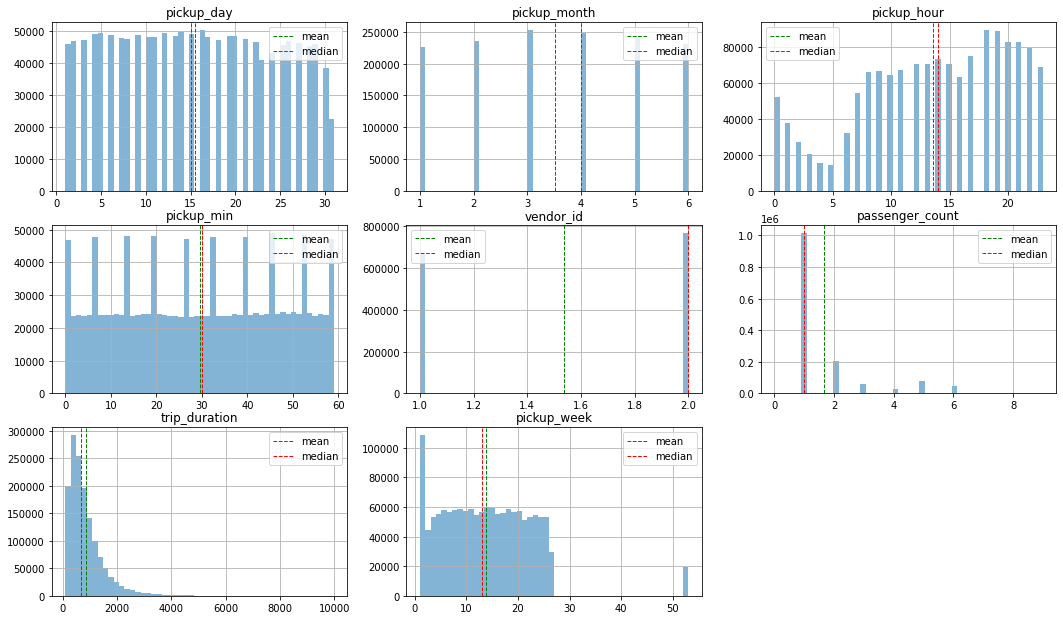

In [18]:
#plotting distribution plot for each variable
num_columns=['pickup_day','pickup_month','pickup_hour','pickup_min','vendor_id','passenger_count','trip_duration','pickup_week']
for col in num_columns:
  i=num_columns.index(col)+1
  plt.subplot(5,3,i)
  df1[col].hist(bins=50,figsize=(18,18),alpha=0.55)
  mean=df1[col].mean()
  median=df1[col].median()
  plt.axvline(mean, color='green', linestyle='dashed', linewidth=1,label='mean')
  plt.axvline(median,color='red',linestyle='dashed', linewidth=1,label='median')
  plt.legend()
  plt.title(col)

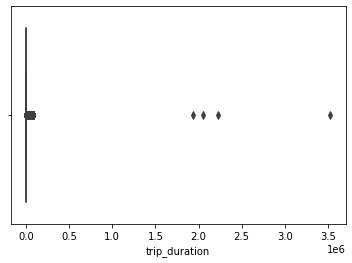

In [13]:
sns.boxplot(df1['trip_duration'])

#We have outliers, so we remove them:
1. First in trip duration we remove those trips which lasted for less than 100 seconds
2. Next we also remove those trips which lasted more than 10000 seconds.

In [14]:
df1=df1[df1['trip_duration']>100]
df1=df1[df1['trip_duration']<10000]

In [15]:
df1.shape

(1437232, 15)

In [ ]:
colors=['coral','red','cyan','orange','plum','teal','gold','indianred','lime','indigo','seagreen','cornflowerblue','lawngreen','deepskyblue','chocolate']
for col in num_columns:
  i=num_columns.index(col)+1
  plt.subplot(5,3,i)
  var=df[col]
  g=sns.regplot(var, np.log10(df['trip_duration']),color=colors[i-1])
  g.figure.set_size_inches(18,28)
  plt.title(col)

#Here we see that none of the variables have a linear relation with trip duration. So, we cannot apply linearr regression.
#Even if we try to implement logistic regression the r2 score is negative, with ridge and lasso we bring it very close to zero. But elasticnet made it positive. However the adjusted r2 score was still less than one.

#Applying Random forest

In [20]:
df1.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week
0,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,14,3,17,24,11
1,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,12,6,0,43,23
2,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,19,1,11,35,3
3,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6,4,19,32,14
4,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,26,3,13,30,12


In [21]:
df1['store_and_fwd_flag'].value_counts() # we remove this column because of output

N    1429370
Y       7862
Name: store_and_fwd_flag, dtype: int64

In [22]:
df1.drop(columns=['store_and_fwd_flag'],inplace=True)

In [23]:
df1.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'pickup_day', 'pickup_month',
       'pickup_hour', 'pickup_min', 'pickup_week'],
      dtype='object')

In [24]:
df1=pd.get_dummies(df1, columns=['vendor_id'],prefix=['vid'])

In [25]:
df1.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week,vid_1,vid_2
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,14,3,17,24,11,0,1
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,12,6,0,43,23,1,0
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,19,1,11,35,3,0,1
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,6,4,19,32,14,0,1
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,26,3,13,30,12,0,1


In [26]:
df1['passenger_count'].unique()

array([1, 6, 4, 2, 3, 5, 0, 9, 8])

In [27]:
#we remove those rows were we have no passengers
df1=df1[df1['passenger_count']!=0]

In [28]:
df1['passenger_count'].unique()

array([1, 6, 4, 2, 3, 5, 9, 8])

In [29]:
def get_passenger_value(X):
  ''' RETURNS A VALUE DEPENDING ON NUMBER OF PASSENGERS'''
  if X==1:
    A=1
  elif 1<X<6:
    A=2
  else:
    A=3
  return A

In [30]:
df1['passenger_count']=df1['passenger_count'].apply(get_passenger_value)

In [31]:
pip install haversine

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
#Now, we get distance as well
import haversine as hs
def get_distance(start_lat,start_long,end_lat,end_long):
  loc1=(start_lat,start_long)
  loc2=(end_lat,end_long)
  return hs.haversine(loc1,loc2)


In [33]:
df1['distance_in_km']=df1.apply(lambda X: get_distance(X['pickup_latitude'],X['pickup_longitude'],X['dropoff_latitude'],X['dropoff_longitude']),axis=1)

In [34]:
df1.head()

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week,vid_1,vid_2,distance_in_km
0,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,455,14,3,17,24,11,0,1,1.498523
1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,663,12,6,0,43,23,1,0,1.805510
2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,2124,19,1,11,35,3,0,1,6.385107
3,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,429,6,4,19,32,14,0,1,1.485500
4,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,435,26,3,13,30,12,0,1,1.188590


In [35]:
df1=df1.drop(columns=['pickup_datetime','dropoff_datetime'],axis=1)

In [36]:
df1.head()

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pickup_day,pickup_month,pickup_hour,pickup_min,pickup_week,vid_1,vid_2,distance_in_km
0,1,-73.982155,40.767937,-73.964630,40.765602,455,14,3,17,24,11,0,1,1.498523
1,1,-73.980415,40.738564,-73.999481,40.731152,663,12,6,0,43,23,1,0,1.805510
2,1,-73.979027,40.763939,-74.005333,40.710087,2124,19,1,11,35,3,0,1,6.385107
3,1,-74.010040,40.719971,-74.012268,40.706718,429,6,4,19,32,14,0,1,1.485500
4,1,-73.973053,40.793209,-73.972923,40.782520,435,26,3,13,30,12,0,1,1.188590


In [37]:
X=df1[list(set(df1.columns)-{'trip_duration'})]
Y=df1['trip_duration']

In [38]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.25, random_state=1)

In [39]:
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn import tree
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from sklearn.inspection import permutation_importance


In [40]:
tree_reg = DecisionTreeRegressor(criterion='squared_error',splitter='best',max_depth=10,min_samples_split=10000,min_samples_leaf=1000)

In [41]:
tree_reg.fit(X_train,Y_train)

DecisionTreeRegressor(max_depth=10, min_samples_leaf=1000,
                      min_samples_split=10000)

In [42]:
y_pred=tree_reg.predict(X_test)

In [43]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

In [44]:
r2_score(Y_test,y_pred)

0.6941072326465905

In [45]:
def get_adjusted_r2(X,Y): #X is actual and Y is pred
  return 1-(1-r2_score(X,Y))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1))

In [46]:
#train errors and test errors
print(f'r2 score for train data is {r2_score(Y_train,tree_reg.predict(X_train))}')
print(f'r2 score for test data is{get_adjusted_r2(Y_test,y_pred)}')
print(f'adjusted r2 score for train data is{get_adjusted_r2(Y_train,tree_reg.predict(X_train))}')
print(f'adjusted r2 score for test data is{get_adjusted_r2(Y_test,y_pred)}')

r2 score for train data is 0.6942221431827678
r2 score for test data is0.6940961647212163
adjusted r2 score for train data is0.6942110794151293
adjusted r2 score for test data is0.6940961647212163


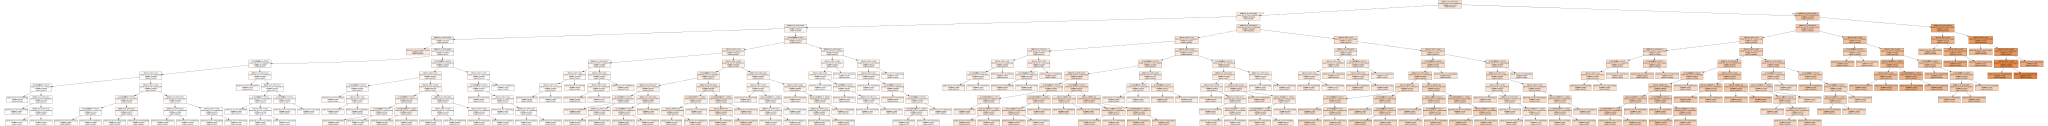

In [47]:
graph = Source(tree.export_graphviz(tree_reg, out_file=None
   , feature_names=X_train.columns, filled = True))
display(SVG(graph.pipe(format='svg')))

In [48]:
tree_reg.feature_importances_

array([0.00000000e+00, 4.76478431e-04, 3.25993570e-03, 7.62024184e-02,
       1.80364624e-03, 0.00000000e+00, 0.00000000e+00, 8.95912364e-01,
       1.87143526e-02, 0.00000000e+00, 3.63080437e-03, 0.00000000e+00,
       0.00000000e+00])

Text(0.5, 0, 'Random Forest Feature Importance')

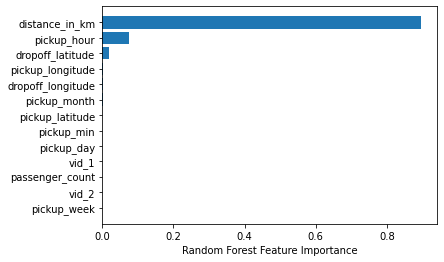

In [49]:
sorted_idx = tree_reg.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], tree_reg.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [50]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 3.7 MB/s 


In [51]:
import shap

In [52]:
explainer = shap.TreeExplainer(tree_reg)
shap_values = explainer.shap_values(X_test)

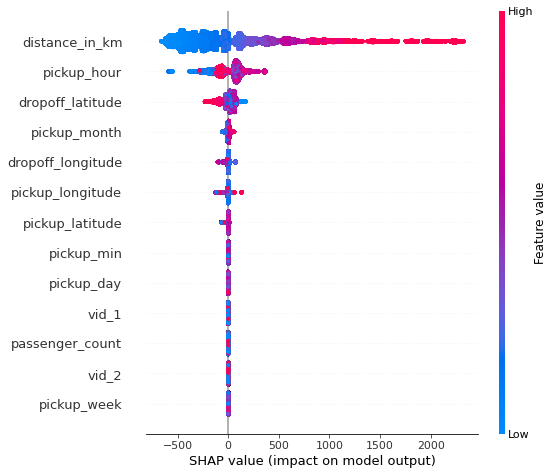

In [53]:
shap.summary_plot(shap_values, X_test)

In [54]:
from sklearn.ensemble import RandomForestRegressor

In [55]:
#number of trees
n_estimators=[50,100]

#maximum depth of trees
max_depth=[5,8,10]

#Minimum number of samples required to split a node
min_samples_split=[1000,10000]

#min sample leaf
min_samples_leaf=[1000]

#hyperparameter grid
param_disct = {'n_estimators':n_estimators,
               'max_depth':max_depth,
               'min_samples_split':min_samples_split}


In [ ]:
#initializing random forest model
rf_model=RandomForestRegressor()

#GridsearchCV
from sklearn.model_selection import GridSearchCV  
rf_grid=GridSearchCV(estimator=rf_model, param_grid=param_disct, 
                     cv=4,verbose=2,scoring='neg_mean_squared_error')

rf_grid.fit(X_train,Y_train)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
[CV] END max_depth=5, min_samples_split=1000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=100; total time= 4.7min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=100; total time= 4.8min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=100; total time= 4.8min
[CV] END max_depth=5, min_samples_split=1000, n_estimators=100; total time= 4.8min
[CV] END max_depth=5, min_samples_split=10000, n_estimators=50; total time= 2.4min
[CV] END max_depth=5, min_samples_split=10000, n_estimators=50; total time= 2.3min
[CV] END max_depth=5, min_samples_split=10000, n_estimators=50; total time= 2.3min
[CV] END max_depth=5, min_samp